## Simulation without incidents

## 2500m inclined well

### Importing neccesary libraries

In [2]:
# Warnings are provided to warn the developer of situations that aren’t necessarily exceptions. 
#Usually, a warning occurs when there is some obsolete of certain programming elements.
#Python program terminates immediately if an error occurs. Conversely, a warning is not critical.

import warnings
warnings.filterwarnings('ignore')

In [1]:
import openlab
import matplotlib.pyplot as plt
import numpy as np
import time
import pandas as pd
import time
import random
import pprint as pr
from IPython.display import clear_output
import datetime
import os
import subprocess
import seaborn as sns

### Logging in and creating session

In [3]:
username="hh.kjolle@stud.uis.no"
apikey="8D44DA8C3A7BDC651D325F0476A2AB776938FE99D57050559EF951D33ABCCFAB"
licenseguid="c3a0315b-813c-4e0b-8ec9-e14436a1783d"

In [4]:
session = openlab.http_client(username=username, apikey=apikey,licenseguid=licenseguid) #this intializes an http client that can be used for an entire openlab session

19:40:54 [INFO] Initializing Openlab http client
19:40:54 [INFO] Creating token
19:40:54 [INFO] Saving token
19:40:54 [INFO] Login Succesfull


### Simulation information

In [5]:
# each simulation lasts 2 minutes, and there are to be 98 simulations with varying setpoints.
single_simulation_lenght = 10 #min
total_simulation_length = 10/60 #hrs

step_per_sim = single_simulation_lenght*60
nr_sim = int(total_simulation_length*60/single_simulation_lenght)
total_steps = nr_sim*step_per_sim

print(f"There will be {nr_sim} simulations, lasting for {single_simulation_lenght} minutes, equalling to {total_steps} timeSteps.")

There will be 1 simulations, lasting for 10 minutes, equalling to 600 timeSteps.


### Normal Drilling

In [6]:
sim_name = "validation"
config_name = "InclinedWell"
initial_bit_depth = 2500 

#### Starting simulation of normal drilling

In [7]:
sim = session.create_simulation(config_name, sim_name, initial_bit_depth)

19:40:55 [INFO] User limits: {'ActiveSimulationCount': 0, 'MaxConcurrentSimulations': 5, 'MaxSimulationCount': 0, 'MaxStepCount': 180000, 'MaxStoredSimulations': 10, 'MaxTimeStep': 18000, 'TotalSimulationCount': 1677, 'UsedCapacityPercent': 9, 'UsedStepCount': 16053}
19:40:55 [INFO] No influx mode selected. Defaulting to 'NoInfluxLoss'
19:41:10 [INFO] Simulation Initialized


#### Unit Converter

In [8]:
FLOW_UNIT_CONV_FACTOR= 1.66666667 * 0.00001#float("10e-5") # l/min --> m^3/s
PRESSURE_CONV_FACTOR= 100000.0 # float("10e5") # bar-->pascal
WEIGHT_CONV_FACTOR = 0.001 # float ("10e3") # kg to tons

### Avaliable setpoints

In [9]:
print(openlab.setpoints.all_setpoints())

['ChokeOpening', 'FlowRateIn', 'TopOfStringVelocity', 'DesiredROP', 'SurfaceRPM', 'ChokePumpFlowRateIn', 'BopChokeOpening', 'MainPitActive', 'MainPitReturn', 'ControlActivePit', 'ControlActivePitDensity', 'ControlActivePitTemperature', 'WOBAutoDriller', 'DesiredWOB', 'WOBProportionalGain', 'WOBIntegralGain']


In [10]:
# variable setpoints
# random lists
SurfaceRPM = [random.randint(0, 220) for _ in range(nr_sim)]
SurfaceRPM = [rpm/60 for rpm in SurfaceRPM]

DesiredWOB = [random.randint(0, 40) for _ in range(nr_sim)]
DesiredWOB = [wob*1000 for wob in DesiredWOB]

FlowRateIn = [random.randint(0, 3000) for _ in range(nr_sim)]
FlowRateIn = [flow_rate/60000 for flow_rate in FlowRateIn]

### Results that is possible to obtain from OpenLab

In [11]:
print(openlab.results.all_results())

['SPP', 'DownholeECD', 'FlowRateOut', 'HookLoad', 'SurfaceTorque', 'BitDepth', 'TD', 'ChokeOpening', 'DownholePressure', 'ChokePressure', 'FluidTemperatureOut', 'WOB', 'InstantaneousROP', 'BopChokeOpening', 'FlowRateIn', 'TopOfStringVelocity', 'SurfaceRPM', 'ChokePumpFlowRateIn', 'DrillstringTemperature', 'TotalInfluxMass', 'CalculatedPressureBottomHole', 'CuttingsMassFractionTransient', 'GasVolumeFraction', 'DrillstringBucklingLimit', 'FluidTemperatureIn', 'AnnulusECD', 'DrillstringTorqueLimit', 'AnnulusTemperature', 'DrillstringTension', 'AnnulusFluidVelocity', 'DrillstringFluidVelocity', 'CuttingsBedHeight', 'AnnulusDensity', 'DrillstringTorque', 'TotalMudLossMass', 'Connection', 'TopOfStringPosition', 'ActivePitVolume', 'ActivePitDensity', 'ActivePitTemperature', 'MainPitVolume', 'MainPitDensity', 'MainPitTemperature', 'ReservePitVolume', 'ReservePitDensity', 'ReservePitTemperature', 'GasFlowRateOut', 'DrillstringDensity']


### The desired tags we want to get from OpenLab, just add and remove

In [12]:
# dataframe and tags stuff
tags = ['SPP', 'DownholeECD', 'FlowRateOut', 'HookLoad', 'SurfaceTorque', 'BitDepth', 'ChokeOpening', 'DownholePressure', 'ChokePressure', 'FluidTemperatureOut', 'WOB', 'InstantaneousROP', 'BopChokeOpening', 'FlowRateIn', 'TopOfStringVelocity', 'SurfaceRPM', 'ChokePumpFlowRateIn', 'DrillstringTemperature', 'TotalInfluxMass', 'CalculatedPressureBottomHole', 'CuttingsMassFractionTransient', 'GasVolumeFraction', 'DrillstringBucklingLimit', 'FluidTemperatureIn', 'AnnulusECD', 'DrillstringTorqueLimit', 'AnnulusTemperature', 'DrillstringTension', 'AnnulusFluidVelocity', 'DrillstringFluidVelocity', 'AnnulusDensity', 'DrillstringTorque', 'TotalMudLossMass', 'TopOfStringPosition', 'ActivePitVolume', 'ActivePitDensity', 'ActivePitTemperature', 'MainPitVolume', 'MainPitDensity', 'MainPitTemperature', 'GasFlowRateOut', 'DrillstringDensity']
ID = ["sim_ID", "timeStep"]
columns = tags + ID


df = pd.DataFrame(columns=columns)

### Running through the simulations

In [13]:
startTime = 1
endTime = single_simulation_lenght*60

timeStep = 1
current_simulation = 0

sim.stop()

while current_simulation < nr_sim:
    
    print(f"Simulation {current_simulation + 1}/{nr_sim}")
    
    sim_ID = current_simulation
    
    sim = session.create_simulation(config_name, sim_name, initial_bit_depth)
    
    sim.setpoints.SurfaceRPM = SurfaceRPM[0+current_simulation]
    sim.setpoints.DesiredWOB = DesiredWOB[0+current_simulation]
    sim.setpoints.FlowRateIn = FlowRateIn[0+current_simulation]
    sim.setpoints.TopOfStringVelocity = 0.02 #m/s
    sim.setpoints.DesiredROP = 0.02
    values = {}
    while timeStep <= endTime:

        sim.step(timeStep) # stepping openlab
        sim.get_results(timeStep, tags) # fetching results

        for feature in tags:
            # Skip "Connection" feature
            if feature == "Connection":
                continue
            # Create the variable name for the current feature
            var_name = f"{feature}"
            # Extract the value of the feature at this time step
            value_dict = eval(f"sim.results.{var_name}")
            value = list(value_dict.values())[-1]  # Extract the value as a number
            # Add the value to the dictionary
            values[feature] = value

        # Update other variables based on the current time step and simulation ID, and add them to the dictionary
        values['timeStep'] = timeStep
        values['sim_ID'] = sim_ID

        # Append the dictionary to the dataframe
        df = df.append(values, ignore_index=True)
        print(df.tail(1))
        clear_output(wait=True)
        
        # Increment the time step
        timeStep += 1

    # Print the entire dataframe after the inner while loop has completed
    print(df)
    
    sim.stop()
    timeStep = 1
    current_simulation += 1

print("All simulations completed.")

19:43:56 [INFO] Ending simulation e158d1e1-a486-442a-90e2-4dde1acb20fa
19:43:56 [INFO] e158d1e1-a486-442a-90e2-4dde1acb20fa was completed


              SPP  DownholeECD   FlowRateOut       HookLoad  SurfaceTorque  \
0    2.214275e+05  1679.210260 -1.862543e-07  242898.158268   11359.751308   
1    1.372874e+06  1679.210699 -2.100802e-07  242449.102790   11443.302224   
2    1.875631e+06  1679.273689  2.362959e-05  242366.038128   11561.178286   
3    2.506508e+06  1683.772648  3.401157e-04  242235.179209   11586.115662   
4    3.077012e+06  1707.840447  2.411699e-04  242065.527568   11598.448837   
..            ...          ...           ...            ...            ...   
595  9.733507e+06  1712.014045  2.702031e-02  -27774.196724   74336.918726   
596  9.733755e+06  1712.013951  2.702024e-02  -28115.925036   74575.351939   
597  9.734003e+06  1712.013880  2.702016e-02  -28454.139818   74808.323411   
598  9.734253e+06  1712.013834  2.702009e-02  -28795.747728   75045.333957   
599  9.734505e+06  1712.013813  2.702002e-02  -29137.007107   75280.439545   

        BitDepth  ChokeOpening  DownholePressure  ChokePressure

### A plot to see that the DownholePressure graph is as it should be

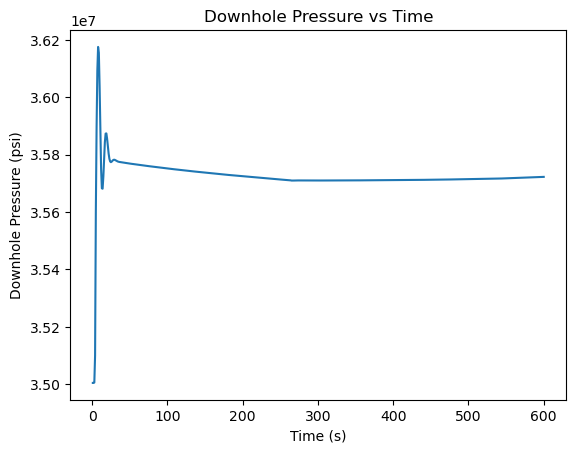

In [14]:
# Extract the downhole pressure and timeStep from the df DataFrame
downhole_pressure = df['DownholePressure']
time_step = df['timeStep']

# Create a line plot
plt.plot(time_step, downhole_pressure)

# Add labels and title
plt.xlabel('Time (s)')
plt.ylabel('Downhole Pressure (psi)')
plt.title('Downhole Pressure vs Time')

# Show the plot
plt.show()


### Saving the df to a csv file, change to your folder directory

In [25]:
# specify the full path to the folder where the file is saved
folder_path = r"C:\Users\262611\OneDrive - Universitetet i Stavanger\Bachelor\python\tutorial\Bachelor\Feature Selection and Cleaning"

# specify the simulation identifier used to save the file
simulation_id = "validation"

# specify the current date and time as a string
current_time = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

# create the folder if it does not exist
os.makedirs(folder_path, exist_ok=True)

# construct the full path to the CSV file to write
file_name = f"results_{simulation_id}_{current_time}.csv"
file_path = os.path.join(folder_path, file_name)

# write the DataFrame to a CSV file
df.to_csv(file_path, index=False)

# read the CSV file into a pandas DataFrame
df = pd.read_csv(file_path)

# open the CSV file using the default program associated with CSV files
if os.name == 'nt':  # for Windows
    os.startfile(file_path)
else:  # for Mac and Linux
    subprocess.call(('open', file_path))

# Display the content of the CSV file in the notebook
display(df)

C:\Users\262611\OneDrive - Universitetet i Stavanger\Bachelor\python\tutorial\Bachelor\Feature Selection and Cleaning/results_validation_2023-04-10_11-31-57.csv?
[0]	cancel
[1]	Open the file C:\Users\262611\OneDrive - Universitetet i Stavanger\Bachelor\python\tutorial\Bachelor\Feature Selection and Cleaning/results_validation_2023-04-10_11-31-57.csv
[2]	Open the URL  (null)

Which did you mean? 

Cancelled.


,SPP,DownholeECD,FlowRateOut,HookLoad,SurfaceTorque,BitDepth,ChokeOpening,DownholePressure,ChokePressure,FluidTemperatureOut,...,ActivePitVolume,ActivePitDensity,ActivePitTemperature,MainPitVolume,MainPitDensity,MainPitTemperature,GasFlowRateOut,DrillstringDensity,sim_ID,timeStep
0,2.214275e+05,1679.210260,-1.862543e-07,242898.158268,11359.751308,2500.001000,1.0,3.500477e+07,101325.0,283.150000,...,30.000000,1650.000000,323.150000,30.000000,1650.000000,323.150000,0.0,"[{'d': 2494.535, 'v': 1664.477802407793}, {'d'...",0,1
1,1.372874e+06,1679.210699,-2.100802e-07,242449.102790,11443.302224,2500.001000,1.0,3.500477e+07,101325.0,283.150000,...,29.998333,1650.000000,323.150000,29.998333,1650.000000,323.150000,0.0,"[{'d': 2494.535, 'v': 1664.6547862454872}, {'d...",0,2
2,1.875631e+06,1679.273689,2.362959e-05,242366.038128,11561.178286,2500.001000,1.0,3.500608e+07,101325.0,283.150001,...,29.995000,1650.000000,323.150000,29.995000,1650.000000,323.150000,0.0,"[{'d': 2494.535, 'v': 1664.9071602520805}, {'d...",0,3
3,2.506508e+06,1683.772648,3.401157e-04,242235.179209,11586.115662,2500.001000,1.0,3.509960e+07,101325.0,283.150004,...,29.990000,1650.000000,323.150000,29.990000,1650.000000,323.150000,0.0,"[{'d': 2494.535, 'v': 1664.4197002565625}, {'d...",0,4
4,3.077012e+06,1707.840447,2.411699e-04,242065.527568,11598.448837,2500.001000,1.0,3.559986e+07,101325.0,283.150009,...,29.983333,1650.000000,323.150000,29.983333,1650.000000,323.150000,0.0,"[{'d': 2494.535, 'v': 1664.9943862667164}, {'d...",0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,9.733507e+06,1712.014045,2.702031e-02,-27774.196724,74336.918726,2502.827735,1.0,3.572224e+07,101325.0,283.520901,...,26.588735,1662.947478,308.202718,26.588735,1662.947478,308.202718,0.0,"[{'d': 2497.361734665654, 'v': 1687.1211793648...",0,596
596,9.733755e+06,1712.013951,2.702024e-02,-28115.925036,74575.351939,2502.836606,1.0,3.572235e+07,101325.0,283.519864,...,26.589014,1662.969093,308.177168,26.589014,1662.969093,308.177168,0.0,"[{'d': 2497.3706061934317, 'v': 1687.151585370...",0,597
597,9.734003e+06,1712.013880,2.702016e-02,-28454.139818,74808.323411,2502.845478,1.0,3.572246e+07,101325.0,283.518824,...,26.589293,1662.990685,308.151643,26.589293,1662.990685,308.151643,0.0,"[{'d': 2497.3794777212097, 'v': 1687.181978168...",0,598
598,9.734253e+06,1712.013834,2.702009e-02,-28795.747728,75045.333957,2502.854349,1.0,3.572257e+07,101325.0,283.517783,...,26.589573,1663.012253,308.126145,26.589573,1663.012253,308.126145,0.0,"[{'d': 2497.3883492489877, 'v': 1687.212359159...",0,599
